In [1]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side

from operator import add, mul, truediv, sub

from operator import itemgetter


from fractions import Fraction


In [296]:
ArithmeticExpr = ANTLR(r"""
grammar arithmetic;
ignoblebug: expr;

s : expr EOF;



expr                                                      // TODO: parentesizzazione semplice efficiente
   : (PLUS | MINUS)? (INT|RAT|REAL)   # atomExpr
   | <assoc=right>expr POW expr           # powExpr
   | expr FRACT expr                      # FractExpr
   | (PLUS | MINUS) expr                  # unaryExpr
   | expr (TIMES | DIV) expr              # divProdExpr
   | expr (PLUS | MINUS) expr             # addSubExpr
   | ROUND_L_BRACK expr ROUND_R_BRACK     # roundBlockExpr
   | CURLY_L_BRACK expr CURLY_R_BRACK     # curlyBlockExpr
   | SQUARE_L_BRACK expr SQUARE_R_BRACK   # squareBlockExpr
   | ROUND_L_BRACK expr ROUND_R_BRACK     # roundBlockExpr
   | SUBEXP_L_BRACK expr SUBEXP_R_BRACK   # subExpr
   ;


INT
   : NUM 
   ;
   
RAT
    : NUM FRACT NUM
    ;

REAL
   : NUM ('.' NUM +)? (E SIGN? NUM)?
   ;
   
NUM
   : ('0' .. '9')
   ;   


fragment E
   : 'E' | 'e'
   ;
   
fragment SIGN
   : ('+' | '-')
   ;
   
CURLY_L_BRACK : '{' ;
CURLY_R_BRACK : '}' ;
SQUARE_L_BRACK : '[' ;
SQUARE_R_BRACK : ']' ;
ROUND_L_BRACK : '(' ;
ROUND_R_BRACK : ')' ;
SUBEXP_L_BRACK : '<' ;
SUBEXP_R_BRACK : '>' ;
PLUS   : '+' ;
MINUS  : '-' ;
TIMES  : 'x' ;
DIV    : ':' ;
POINT  : '.' ;
POW    : '^' ;
FRACT  : '/' ;

WS
   : [ \r\n\t] + -> skip
   ;
   

""")

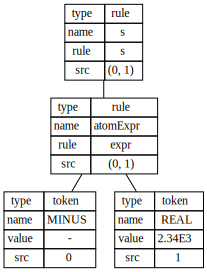

In [299]:
expr = """
1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x (9 : (2 + 1) + 2)
"""

expr = '-2.34E3'


ptree = ArithmeticExpr.tree(expr, 's')
ptree

In [305]:
arith2ast = AnnotatedTreeWalker('name')


PRIORITY = {
    'graphBlockExpr' : 8,
    'squareBlockExpr' : 7,
    'roundBlockExpr' : 6,
    'powExpr' : 5,
    'unaryExpr' : 4,
    'fractExpr' : 3,
    'divProdExpr' : 2,
    'addSubExpr' : 1
}

@arith2ast.register
def RAT(visit, ptree):
    return Fraction(ptree.root['value'])

@arith2ast.register
def INT(visit, ptree):
    return int(ptree.root['value'])

@arith2ast.register
def REAL(visit, ptree):
    return float(ptree.root['value'])

@arith2ast.register
def atomExpr(visit, ptree):
    if len(ptree.children) > 1:
        value = -visit(ptree.children[1])
    else:
        value = visit(ptree.children[0])
    return Tree({'type': 'atomExpr', 'value': value, 'grade': 0}, []), 0

@arith2ast.register
def addSubExpr(visit, ptree):
    left, op, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['addSubExpr'])

    return Tree({'type': 'addSubExpr', 'op': op.root['value'], 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def divProdExpr(visit, ptree):
    left, op, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['divProdExpr'])    

    return Tree({'type': 'divProdExpr', 'op': op.root['value'], 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def powExpr(visit, ptree):
    left, _, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['powExpr'])  
    
    return Tree({'type': 'powExpr', 'priority': priority, 'grade': grade}, [left, right]), priority

@arith2ast.register
def unaryExpr(visit, ptree):
    op, subexpr = ptree.children
    subexpr, subexpr_priority = visit(subexpr)
    
    grade = subexpr.root['grade']
    priority = max(subexpr_priority, PRIORITY['unaryExpr'])  
    
    return Tree({'type': 'unaryExpr', 'op': op.root['value'],'priority': priority, 'grade': grade}, [subexpr]), subexpr_priority



@arith2ast.register
def fractExpr(visit, ptree):
    left, _, right = ptree.children
    left, left_priority = visit(left)
    right, right_priority = visit(right)
    
    grade = max(left.root['grade'], right.root['grade'])
    priority = max(left_priority, right_priority, PRIORITY['fractExpr'])   
    
    return Tree({'type': 'fractExpr', 'priority': priority, 'grade': grade}, [left, right]), priority


@arith2ast.register
def roundBlockExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr, subexpr_priority = visit(subexpr)
    
    grade = subexpr.root['grade'] + 1
    priority = PRIORITY['roundBlockExpr']   
        
    if subexpr_priority > priority:
        raise BaseException(f'Annidamento scorretto in posizione: {ptree.root["src"]}')
        
    return Tree({'type': 'roundBlockExpr', 'priority': priority, 'grade': grade}, [subexpr]), priority


@arith2ast.register
def squareBlockExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr, subexpr_priority = visit(subexpr)
    
    grade = subexpr.root['grade'] + 1
    priority = PRIORITY['squareBlockExpr']   
        
    if subexpr_priority > priority:
        raise BaseException(f'Annidamento scorretto in posizione: {ptree.root["src"]}')
        
    return Tree({'type': 'squareBlockExpr', 'priority': priority, 'grade': grade}, [subexpr]), priority

    
@arith2ast.register
def curlyBlockExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    subexpr, subexpr_priority = visit(subexpr)
    
    grade = subexpr.root['grade'] + 1
    priority = PRIORITY['graphBlockExpr']   

    
    return Tree({'type': 'graphBlockExpr', 'priority': priority, 'grade': grade}, [subexpr]), priority
    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth
    

@arith2ast.register
def subExpr(visit, ptree):
    _, subexpr, _ = ptree.children
    return visit(subexpr)
    #depth = depth + 1
    #subexpr.root['depth'] = depth
    #return subexpr, depth
    
@arith2ast.register
def s(visit, ptree):
    ast, _ = visit(ptree.children[0])
    return ast


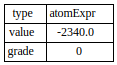

In [307]:
ast = arith2ast(ptree)
ast

In [308]:
def src2ast(source):
    ast = arith2ast(ArithmeticExpr.tree(source, 's'))
    return ast

In [276]:
atw_eval = AnnotatedTreeWalker('type')

ARITH_OP = {
    '+' : add,
    '-' : sub,
    'x' : mul,
    ':' : Fraction,
    '/' : Fraction
}



def find_more_priority_child(ast):
    priorities = [child.root['priority'] if 'priority' in child.root else -1 for child in ast.children]
    grades = [child.root['grade'] for child in ast.children]
    l = list(zip(priorities, grades))
    return l.index(max(l, key=lambda x: float(f'{x[0]}.{x[1]}')))


def is_calculable(ast):
    return ast.root['type'] == 'atomExpr' or all(child.root['type'] == 'atomExpr' for child in ast.children)


@atw_eval.register
def atomExpr(visit, ast):
    grade = 0
    return Tree({'type': ast.root['type'], 'value': ast.root['value'], 'grade': grade}, []), 0

@atw_eval.register
def addSubExpr(visit, ast):
    op = ast.root['op']
    
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)
        
        value = ARITH_OP[op](left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['addSubExpr']])
    
    res = Tree({'type': 'addSubExpr', 'op': op, 'grade' : grade, 'priority': priority}, children)
    
    if is_calculable(res) and ast.children[index_priority_child].root['type'] == 'addSubExpr':
        return visit(res)
    return res, priority
    
    
    

@atw_eval.register
def divProdExpr(visit, ast):
    op = ast.root['op']
    
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = ARITH_OP[op](left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['divProdExpr']])

    res = Tree({'type': 'divProdExpr', 'op': op, 'grade' : grade, 'priority': priority}, children)
    
    if is_calculable(res) and ast.children[index_priority_child].root['type'] == 'divProdExpr':
        return visit(res)
    return res, priority


@atw_eval.register
def powExpr(visit, ast):
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = pow(left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['powExpr']])
    return Tree({'type': 'powExpr', 'grade' : grade, 'priority': priority}, children), priority



@atw_eval.register
def unaryExpr(visit, ast):
    if is_calculable(ast):  
        subexpr, _ = visit(ast.children[0])
        
        value = subexpr.root['value']
        if ast.root['op'] == '-':
            value = -value
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    
    subexpr, grade = visit(ast.children[0])
    
    if 'priority' in subexpr.root:
    else:    
        priority = PRIORITY['unaryExpr']
    return Tree({'type': 'unaryExpr', 'op': ast.root['op'],'grade' : grade, 'priority': priority}, [subexpr]), priority


@atw_eval.register
def fractExpr(visit, ast):
    if is_calculable(ast):  
        left, right = ast.children
        left, _ = visit(left)
        right, _ = visit(right)

        value = Fraction(left.root['value'], right.root['value'])
        grade = 0
        return Tree({'type': 'atomExpr', 'value': value, 'grade': grade}, []), 0
    
    
    index_priority_child = find_more_priority_child(ast)
    children = ast.children.copy()
    children[index_priority_child], _ = visit(ast.children[index_priority_child])
    
    grade = max([child.root['grade'] for child in children if 'grade' in child.root] + [0])
    
    priority = max([child.root['priority'] for child in children if 'priority' in child.root] + [PRIORITY['fractExpr']])
    return Tree({'type': 'fractExpr', 'grade' : grade, 'priority': priority}, children), priority

@atw_eval.register
def roundBlockExpr(visit, ast):
    child, child_priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    priority = PRIORITY['roundBlockExpr']
    res = Tree({'type': 'roundBlockExpr', 'grade': grade_block, 'priority': priority}, [child])
    if is_calculable(res):
        return child, child_priority
    return res, priority


@atw_eval.register
def squareBlockExpr(visit, ast):
    child, child_priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    priority = PRIORITY['squareBlockExpr']
    res = Tree({'type': 'squareBlockExpr', 'grade': grade_block, 'priority': priority}, [child])
    if is_calculable(res):
        return child, child_priority
    return res, priority

@atw_eval.register
def graphBlockExpr(visit, ast):
    child, child_priority = visit(ast.children[0])
    grade_block = child.root['grade'] + 1
    priority = PRIORITY['graphBlockExpr']
    res = Tree({'type': 'graphBlockExpr', 'grade': grade_block, 'priority': priority}, [child])
    if is_calculable(res):
        return child, child_priority
    return res, priority


In [277]:
def step(ast):
    res, _ = atw_eval(ast)
    return res

0

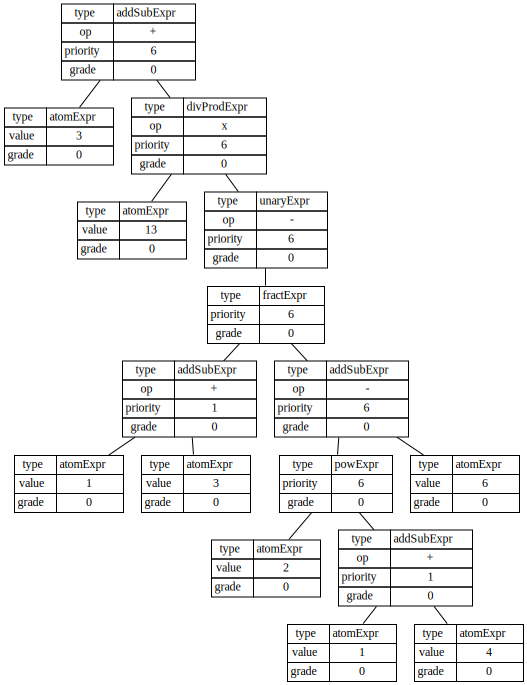

----------------------------------------------------------------------------------------------------


1

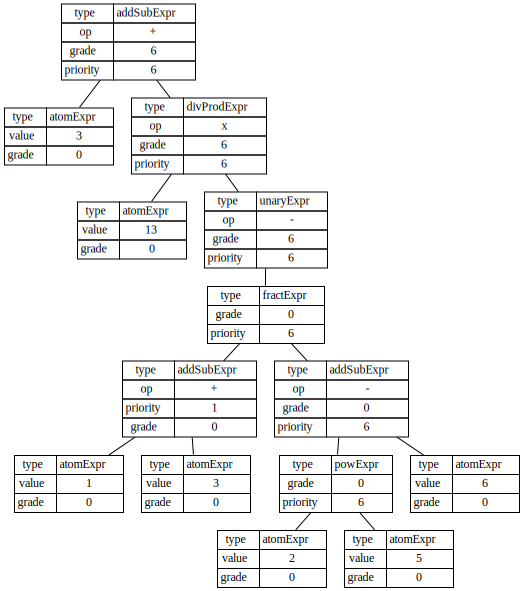

----------------------------------------------------------------------------------------------------


2

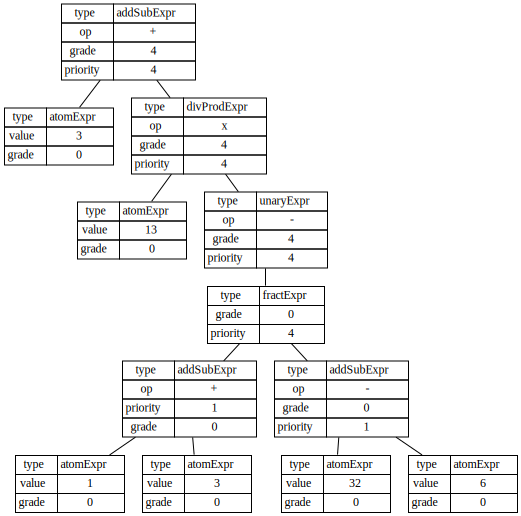

----------------------------------------------------------------------------------------------------


3

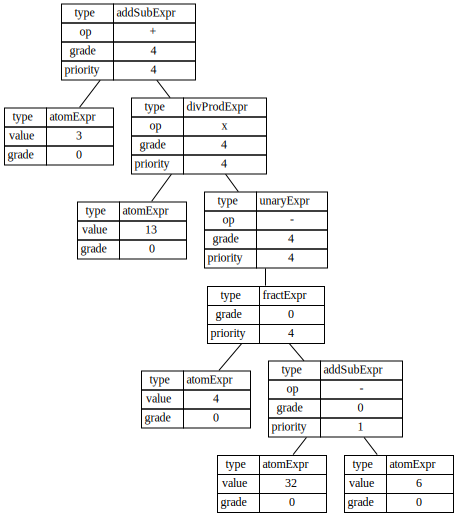

----------------------------------------------------------------------------------------------------


4

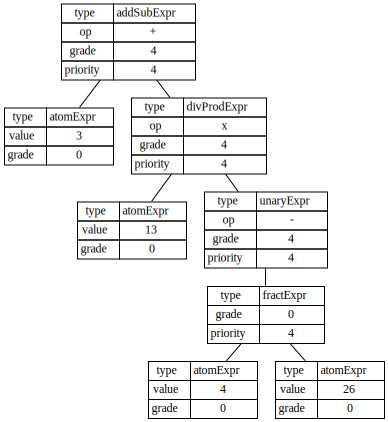

----------------------------------------------------------------------------------------------------


5

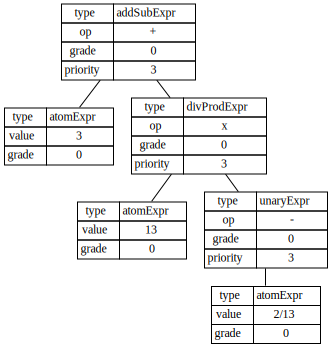

----------------------------------------------------------------------------------------------------


6

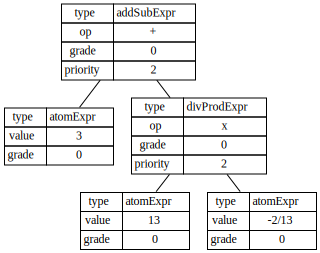

----------------------------------------------------------------------------------------------------


7

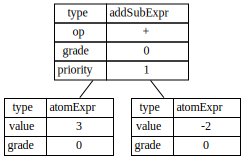

----------------------------------------------------------------------------------------------------


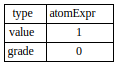

In [279]:
expr = '1 x 8 x 7 x (8 + 7) + (9 x 7 + 8 - (3 + 2+ 3))) - (8 + 9 + 8 + (4))'
ex1 = '1 + (2 x ((3 + 4 : 2) + 5) x 6) - (7 + (1 + 8) : 3) x(9 : (2 + 1) +2)'
ex2 = '<2+3>/4/<5+6>/7'
ex3 = '2^<3+4^5:2^7>'
ex4 = '3 + 13 x -<1 + 3>/<2^<1+4> - 6>'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'
#expr = ex1
expr = ex4

ast = src2ast(expr)
#step(ast)
#step(ast)
count = 0
while ast.children:
    display(count, ast)
    ast = step(ast)
    count += 1
    print('-' * 100)


#display(count, ast)
ast

In [10]:
atw_printer = AnnotatedTreeWalker('type')

In [309]:
atw_latex_formatter = AnnotatedTreeWalker('type')

@atw_latex_formatter.register
def atomExpression(visit, ast):
    fr = Fraction(ast.root['value'])
    if fr.denominator != 1:
        return f'\\frac{{{fr.numerator}}} {{{fr.denominator}}}'
    return str(fr)
    
@atw_latex_formatter.register
def addSubExpression(visit, ast):
    op = ast.root['op']
    
    left, right = ast.children
    left, right = visit(left), visit(right)   
    
    return f'{left} {op} {right}'
    
    
    

@atw_latex_formatter.register
def divProdExpression(visit, ast):
    op = ast.root['op']
    
    left, right = ast.children
    left, right = visit(left), visit(right)
    
    if op == 'x':
        op = '\\times'
        
    return f'{left} {op} {right}'


@atw_latex_formatter.register
def powExpression(visit, ast):
    left, right = ast.children
    left, right = visit(left), visit(right)
    
    return f'{{{left}}}^{{{right}}}'

@atw_latex_formatter.register
def fractExpression(visit, ast):
    
    left, right = ast.children
    left, right = visit(left), visit(right)
    
    return f'\\frac{{{left}}} {{{right}}}'


@atw_latex_formatter.register
def blockExpression(visit, ast):
    child = visit(ast.children[0])
    return f'\\left({child}\\right)'